<a href="https://colab.research.google.com/github/fahadrafiq94/Data-Semantics-/blob/main/Movie_genre_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Libararies

In [ ]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from tensorflow.keras import layers, regularizers

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Becoming one with Data

In [ ]:
# Define column names
column_names = ["Movie Name", "Genre", "Description"]

# Read the CSV into a DataFrame with column names
df = pd.read_csv("/content/drive/MyDrive/movie_genre_prediction/train_data.txt", sep=":::", header=None, names=column_names)


<ipython-input-2-2aaaab22e5bc>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/content/drive/MyDrive/movie_genre_prediction/train_data.txt", sep=":::", header=None, names=column_names)


In [ ]:
df.head()

,Movie Name,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
pd.DataFrame(df.Genre.unique()).values
counts =df.Genre.value_counts()
print(counts)
len(counts)

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: Genre, dtype: int64


27

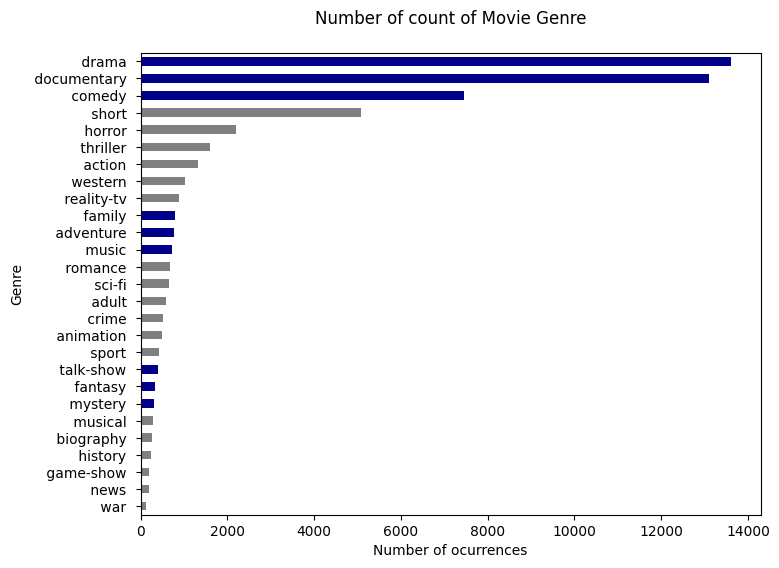

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('Genre').Genre.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Number of count of Movie Genre\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## 3. Preprocessing

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [ ]:
# Apply text preprocessing to the Description
df['Processed_Description'] = df['Description'].apply(preprocess_text)

In [ ]:
df.head()

,Movie Name,Genre,Description,Processed_Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers unrecovered bodies ground z...


In [ ]:
# Use LabelEncoder to encode the 'Genre' column
label_encoder = LabelEncoder()
df['Label_Genre'] = label_encoder.fit_transform(df['Genre'])

In [ ]:
df.head()

,Movie Name,Genre,Description,Processed_Description,Label_Genre
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...,8
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,24
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,1
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,8
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers unrecovered bodies ground z...,8


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df.Description).toarray()

labels = df.Label_Genre

print("Each of the %d Description is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 54214 Description is represented by 70972 features (TF-IDF score of unigrams and bigrams)


## 4. Train Test Split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df["Processed_Description"].to_numpy(),
                                                                            df["Label_Genre"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((48792,), (5422,), (48792,), (5422,))

## 5. Convert text into Vectors

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

57

In [ ]:
df['Processed_Description'].nunique()

54078

In [ ]:
# Setup text vectorization with custom variables
max_length = 102 # max length our sequences will be (e.g. how many words from a description does our model see?)
max_vocab_length = 54078
text_vectorizer = TextVectorization(max_tokens=max_vocab_length ,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "I love this movie"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 102), dtype=int64, numpy=
array([[  1,  10,   1, 101,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
import random
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
based biography olive fredrickson tells life girl trappers wife later widow three small children surviving rugged pioneer conditions northern alberta canada early 1900s depression      

Vectorized version:


<tf.Tensor: shape=(1, 102), dtype=int64, numpy=
array([[  173,  4952,  8951, 33251,   102,     2,    33, 27911,    38,
          117,  1798,    37,    88,    77,  2367,  6560,  5128,  1404,
         1291, 10272,  1100,   337, 15962,  1708,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 54078
Top 5 most common words: ['', '[UNK]', 'life', 'one', 'film']
Bottom 5 least common words: ['sandros', 'sandrini', 'sandpit', 'sandow', 'sando']


## 6. Converting Vectors into Embeddings

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
camille courtesan paris falls deeply love young man promise armand duval armands father begs ruin hopes career position marrying armand acquiesces leaves lover however poverty terminal illness overwhelm camille discovers armand lost love      

Embedded version:


<tf.Tensor: shape=(1, 102, 128), dtype=float32, numpy=
array([[[-0.03875548, -0.04768859, -0.01177871, ...,  0.00088335,
          0.04933796, -0.03682076],
        [ 0.03053646, -0.0251089 ,  0.02964151, ..., -0.02410184,
         -0.03794531, -0.0123053 ],
        [ 0.03772997,  0.01994935,  0.02830033, ..., -0.00322435,
         -0.02630302,  0.02222   ],
        ...,
        [ 0.00263793,  0.01646322,  0.00772778, ..., -0.04621169,
          0.03788881, -0.03271723],
        [ 0.00263793,  0.01646322,  0.00772778, ..., -0.04621169,
          0.03788881, -0.03271723],
        [ 0.00263793,  0.01646322,  0.00772778, ..., -0.04621169,
          0.03788881, -0.03271723]]], dtype=float32)>

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

## 7. LSTM Model

In [ ]:
lstm_embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="lstm_embedding")

lstm_embedding

In [ ]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = lstm_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Description (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(27, activation="softmax")(x)
lstm_model = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 102, 128)
(None, 64)


In [ ]:
# Compile model
lstm_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
lstm_model.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 102)               0         
 Vectorization)                                                  
                                                                 
 lstm_embedding (Embedding)  (None, 102, 128)          6921984   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 27)                1755      
                                                      

In [ ]:
# Fit model
lstm_model_history = lstm_model.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[early_stopping])

Epoch 1/10
1525/1525 [==============================] - 244s 158ms/step - loss: 2.4328 - accuracy: 0.2504 - val_loss: 2.3898 - val_accuracy: 0.2617
Epoch 2/10
1525/1525 [==============================] - 231s 152ms/step - loss: 2.0346 - accuracy: 0.4318 - val_loss: 1.9206 - val_accuracy: 0.4454
Epoch 3/10
1525/1525 [==============================] - 234s 153ms/step - loss: 1.7077 - accuracy: 0.5060 - val_loss: 1.8401 - val_accuracy: 0.4814
Epoch 4/10
1525/1525 [==============================] - 233s 153ms/step - loss: 1.4147 - accuracy: 0.6037 - val_loss: 1.8898 - val_accuracy: 0.4880
Epoch 5/10
1525/1525 [==============================] - 230s 151ms/step - loss: 1.1402 - accuracy: 0.6950 - val_loss: 2.0462 - val_accuracy: 0.4935
Epoch 6/10
1525/1525 [==============================] - 236s 155ms/step - loss: 0.9099 - accuracy: 0.7565 - val_loss: 2.1929 - val_accuracy: 0.4795


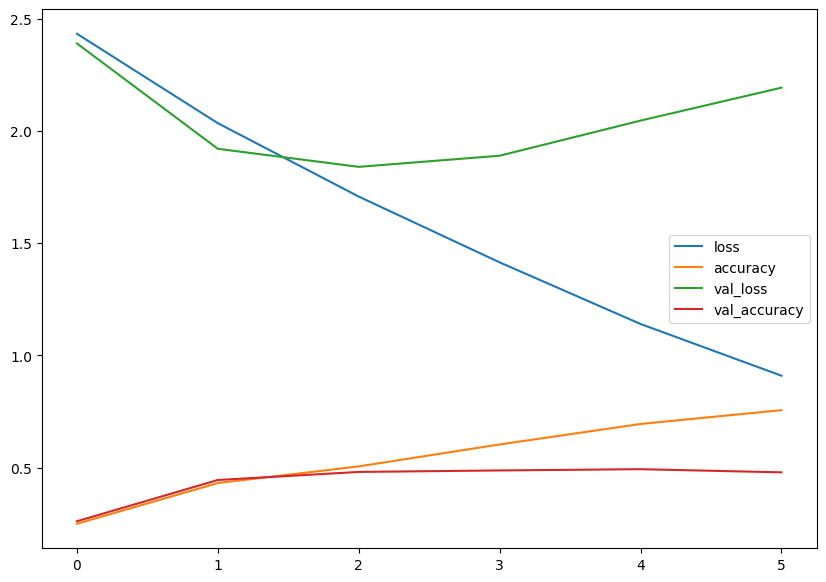

In [ ]:
pd.DataFrame(lstm_model_history .history).plot(figsize=(10, 7));

In [ ]:
# Make predictions on the validation dataset
lstm_model_pred_probs = lstm_model.predict(val_sentences)
lstm_model_pred_probs.shape, lstm_model_pred_probs[:5] # view the first 5

170/170 [==============================] - 3s 17ms/step


((5422, 27),
 array([[3.6638085e-04, 1.0673935e-03, 1.5377467e-04, 2.4234524e-04,
         1.9447607e-05, 9.4010079e-01, 1.4801184e-03, 1.7126449e-05,
         1.9541942e-02, 1.0970942e-03, 2.8190610e-04, 1.9998991e-07,
         1.2022723e-05, 1.0350046e-03, 3.6189139e-08, 2.0307822e-04,
         6.4340449e-04, 7.7559451e-07, 2.4206678e-05, 1.5298122e-02,
         3.5106223e-05, 8.6201103e-03, 8.7849791e-08, 3.4070456e-06,
         9.7348830e-03, 2.0115522e-05, 1.1696562e-06],
        [7.2222571e-03, 4.4590142e-04, 1.2664472e-03, 5.6187937e-04,
         8.8076689e-04, 3.2134954e-02, 1.4646510e-02, 9.3399722e-04,
         7.8764743e-01, 9.7907009e-03, 1.8931744e-03, 1.0707346e-06,
         6.0518784e-04, 3.4767782e-04, 7.5223193e-06, 3.1379936e-03,
         5.0184848e-03, 2.3328419e-05, 1.3039472e-04, 5.0066773e-02,
         4.3674823e-04, 5.6658335e-02, 1.6243206e-05, 9.6181839e-06,
         2.2502778e-02, 2.5777279e-03, 1.0360274e-03],
        [2.2734334e-01, 4.1203443e-02, 2.0928945e

In [ ]:
# Round out predictions and reduce to 1-dimensional array
lstm_models_preds = np.argmax(lstm_model.predict(val_sentences), axis=1)
lstm_models_preds[:10]

170/170 [==============================] - 4s 22ms/step


array([ 5,  8,  0, 13, 14,  8,  7,  0,  7,  8])

In [ ]:
# Calculate LSTM model results
lstm_models_results = calculate_results(y_true=val_labels,
                                    y_pred=lstm_models_preds)
lstm_models_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 47.952784950202876,
 'precision': 0.4564337273740644,
 'recall': 0.47952784950202876,
 'f1': 0.4617424118999359}

## 8. GRU

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
GRU_model_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="GRU_model_embedding")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = GRU_model_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x) # optional dense layer after GRU cell
outputs = layers.Dense(27, activation="softmax")(x)
GRU_model = tf.keras.Model(inputs, outputs, name="model_GRU")

In [ ]:
# Compile GRU model
GRU_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
GRU_model.summary()

Model: "model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 102)               0         
 Vectorization)                                                  
                                                                 
 GRU_model_embedding (Embed  (None, 102, 128)          6921984   
 ding)                                                           
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 27)                17

In [ ]:
# Fit model
GRU_model_history = GRU_model.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[early_stopping])

Epoch 1/10
1525/1525 [==============================] - 231s 150ms/step - loss: 2.3646 - accuracy: 0.2884 - val_loss: 1.9842 - val_accuracy: 0.4286
Epoch 2/10
1525/1525 [==============================] - 227s 149ms/step - loss: 1.7895 - accuracy: 0.4851 - val_loss: 1.7623 - val_accuracy: 0.4893
Epoch 3/10
1525/1525 [==============================] - 226s 148ms/step - loss: 1.4319 - accuracy: 0.5947 - val_loss: 1.7519 - val_accuracy: 0.5100
Epoch 4/10
1525/1525 [==============================] - 227s 149ms/step - loss: 1.1046 - accuracy: 0.6897 - val_loss: 1.8970 - val_accuracy: 0.5059
Epoch 5/10
1525/1525 [==============================] - 228s 149ms/step - loss: 0.8237 - accuracy: 0.7775 - val_loss: 2.1875 - val_accuracy: 0.4867
Epoch 6/10
1525/1525 [==============================] - 225s 148ms/step - loss: 0.6307 - accuracy: 0.8341 - val_loss: 2.4470 - val_accuracy: 0.4769


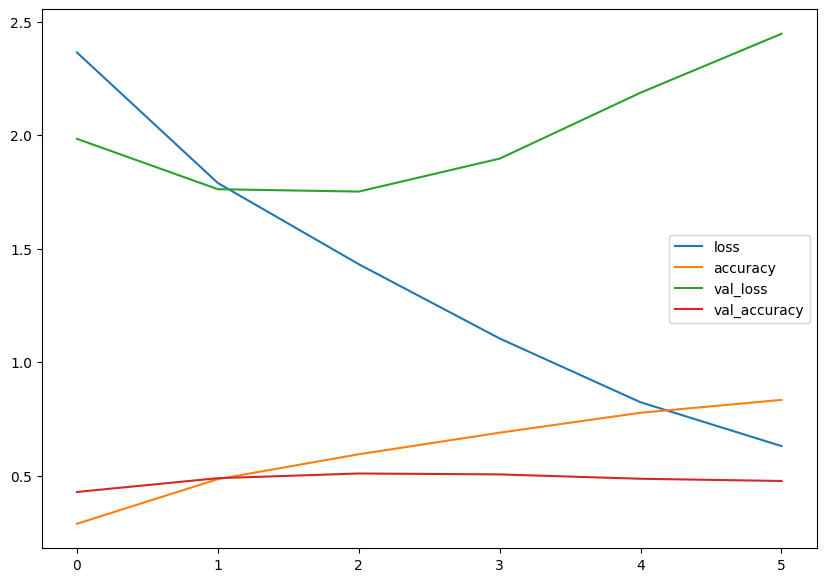

In [ ]:
pd.DataFrame(GRU_model_history.history).plot(figsize=(10, 7));

In [ ]:
# Make predictions on the validation dataset
GRU_model_pred_probs = GRU_model.predict(val_sentences)
GRU_model_pred_probs.shape, GRU_model_pred_probs[:5] # view the first 5

170/170 [==============================] - 4s 23ms/step


((5422, 27),
 array([[6.02031033e-03, 2.23744614e-03, 1.33601003e-04, 4.96701919e-04,
         1.43780911e-04, 5.63549519e-01, 1.47268586e-02, 1.09371278e-04,
         1.24756105e-01, 6.99086906e-03, 2.81126529e-04, 5.40082624e-07,
         3.20972831e-05, 2.69247248e-04, 7.51440120e-06, 2.85484479e-03,
         5.10074897e-03, 1.29370492e-05, 1.18056509e-04, 2.16748536e-01,
         2.14723332e-05, 2.01391932e-02, 1.56106796e-06, 4.16096809e-05,
         3.49072516e-02, 1.20511657e-04, 1.78179267e-04],
        [2.76830222e-04, 7.20081653e-06, 2.85487458e-05, 1.27619705e-05,
         1.02497841e-04, 3.10118264e-03, 1.72654877e-03, 4.08827473e-04,
         9.58767653e-01, 2.23611481e-04, 4.94759333e-05, 1.06505027e-09,
         5.18945089e-05, 1.13157832e-04, 2.21521930e-07, 1.11345907e-04,
         8.18986271e-04, 9.78561843e-07, 1.98652151e-06, 2.51013506e-02,
         1.10016845e-05, 4.62042028e-03, 9.04645816e-08, 4.90311550e-07,
         4.20471234e-03, 2.56039290e-04, 2.20536822e-

In [ ]:
# Round out predictions and reduce to 1-dimensional array
GRU_models_preds = np.argmax(GRU_model.predict(val_sentences), axis=1)
GRU_models_preds[:10]

170/170 [==============================] - 2s 14ms/step


array([ 5,  8,  9, 13, 14, 21,  7,  7,  7, 13])

In [ ]:
# Calculate LSTM model results
GRU_models_results = calculate_results(y_true=val_labels,
                                    y_pred=GRU_models_preds)
GRU_models_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 47.694577646624865,
 'precision': 0.46374713496264347,
 'recall': 0.47694577646624864,
 'f1': 0.4680491734565323}

## Bidirectional

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
bi_directional_model_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="Bi_directional_embedding")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bi_directional_model_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(27, activation="softmax")(x)
bi_d_model = tf.keras.Model(inputs, outputs, name="model_Bidirectional")

In [ ]:
# Compile GRU model
bi_d_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
bi_d_model_history = bi_d_model.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[early_stopping])

Epoch 1/10
1525/1525 [==============================] - 324s 210ms/step - loss: 1.8446 - accuracy: 0.4713 - val_loss: 1.6168 - val_accuracy: 0.5325
Epoch 2/10
1525/1525 [==============================] - 315s 207ms/step - loss: 1.2825 - accuracy: 0.6362 - val_loss: 1.5926 - val_accuracy: 0.5417
Epoch 3/10
1525/1525 [==============================] - 313s 205ms/step - loss: 0.8756 - accuracy: 0.7508 - val_loss: 1.7241 - val_accuracy: 0.5347
Epoch 4/10
1525/1525 [==============================] - 308s 202ms/step - loss: 0.5658 - accuracy: 0.8373 - val_loss: 1.9869 - val_accuracy: 0.5190
Epoch 5/10
1525/1525 [==============================] - 311s 204ms/step - loss: 0.3459 - accuracy: 0.9012 - val_loss: 2.4243 - val_accuracy: 0.5018


<Axes: >

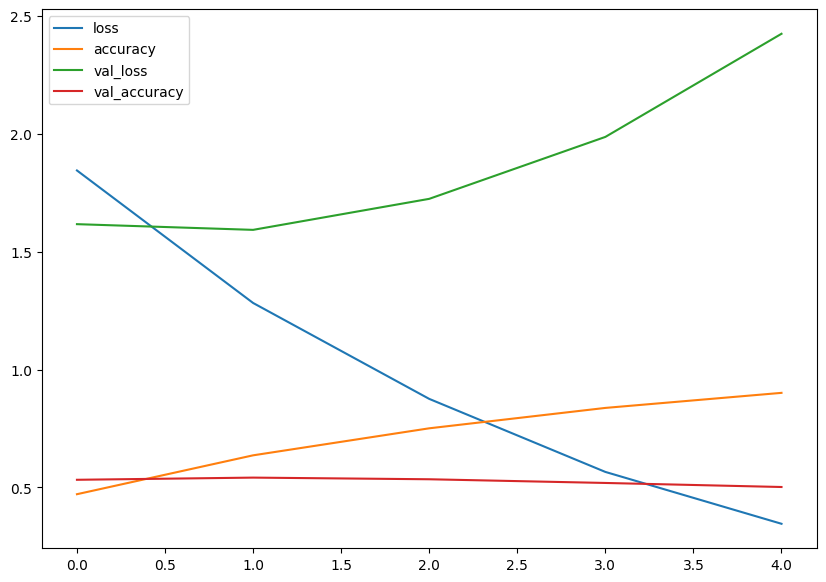

In [ ]:
pd.DataFrame(bi_d_model_history.history).plot(figsize=(10, 7))

In [ ]:
# Make predictions on the validation dataset
bi_d_model_pred_probs = bi_d_model.predict(val_sentences)
bi_d_model_pred_probs.shape, bi_d_model_pred_probs[:5] # view the first 5

170/170 [==============================] - 5s 27ms/step


((5422, 27),
 array([[2.5946659e-03, 6.3222105e-05, 3.4089037e-04, 2.5007187e-06,
         7.7550554e-05, 3.1764813e-02, 5.6762584e-02, 1.2698534e-05,
         6.2977672e-01, 2.1656597e-04, 2.7862105e-05, 1.3025117e-06,
         3.6677382e-05, 5.1150215e-04, 1.5410676e-07, 4.8631311e-05,
         3.3761878e-03, 8.8048927e-07, 1.5473117e-05, 1.7391006e-03,
         3.6793433e-06, 8.5833024e-05, 1.8302515e-07, 1.1984512e-06,
         2.7245665e-01, 5.9171296e-05, 2.3233217e-05],
        [1.2906264e-04, 2.1418071e-04, 1.7244421e-04, 7.1073766e-05,
         3.3231833e-04, 4.7330870e-03, 9.6715416e-04, 2.1053301e-04,
         9.2256272e-01, 4.5459867e-03, 2.8804649e-04, 5.4255918e-07,
         8.4600186e-05, 4.8743907e-05, 8.3848172e-06, 2.7259642e-03,
         8.0141285e-04, 9.5075693e-06, 1.5136629e-04, 5.3597186e-02,
         6.2333847e-06, 6.5924409e-03, 3.7414775e-06, 4.2652473e-06,
         1.6099770e-03, 1.1406173e-04, 1.4761691e-05],
        [1.3809067e-01, 1.2076221e-02, 2.4713561e

In [ ]:
# Round out predictions and reduce to 1-dimensional array
bi_d_models_preds = np.argmax(bi_d_model.predict(val_sentences), axis=1)
bi_d_models_preds[:10]

170/170 [==============================] - 5s 32ms/step


array([ 8,  8,  2, 13, 14,  7,  7, 21,  7,  8])

In [ ]:
# Calculate LSTM model results
bi_d_models_results = calculate_results(y_true=val_labels,
                                    y_pred=bi_d_models_preds)
bi_d_models_results

{'accuracy': 50.18443378827001,
 'precision': 0.4919297427581656,
 'recall': 0.5018443378827001,
 'f1': 0.49391204694198404}

## Transfer Learning

### Feature Extarction

#### On original dataset

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
import tensorflow_hub as hub
sentence_encoder_layer_original = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_USE_original = tf.keras.Sequential([
  sentence_encoder_layer_original, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(27, activation="softmax")
], name="model_USE")

# Compile model
model_USE_original.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE_original.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 27)                1755      
                                                                 
Total params: 256832411 (979.74 MB)
Trainable params: 34587 (135.11 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model
model_USE_original_history = model_USE_original.fit(train_sentences,
                              train_labels,
                              epochs=30,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[early_stopping])

Epoch 1/30
1525/1525 [==============================] - 43s 26ms/step - loss: 1.6912 - accuracy: 0.5140 - val_loss: 1.4612 - val_accuracy: 0.5579
Epoch 2/30
1525/1525 [==============================] - 36s 23ms/step - loss: 1.3987 - accuracy: 0.5669 - val_loss: 1.3838 - val_accuracy: 0.5690
Epoch 3/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.3448 - accuracy: 0.5786 - val_loss: 1.3655 - val_accuracy: 0.5786
Epoch 4/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.3175 - accuracy: 0.5836 - val_loss: 1.3614 - val_accuracy: 0.5769
Epoch 5/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.2985 - accuracy: 0.5885 - val_loss: 1.3478 - val_accuracy: 0.5782
Epoch 6/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.2834 - accuracy: 0.5910 - val_loss: 1.3480 - val_accuracy: 0.5799
Epoch 7/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.2704 - accuracy: 0.5964 - val_loss: 1.3446 -

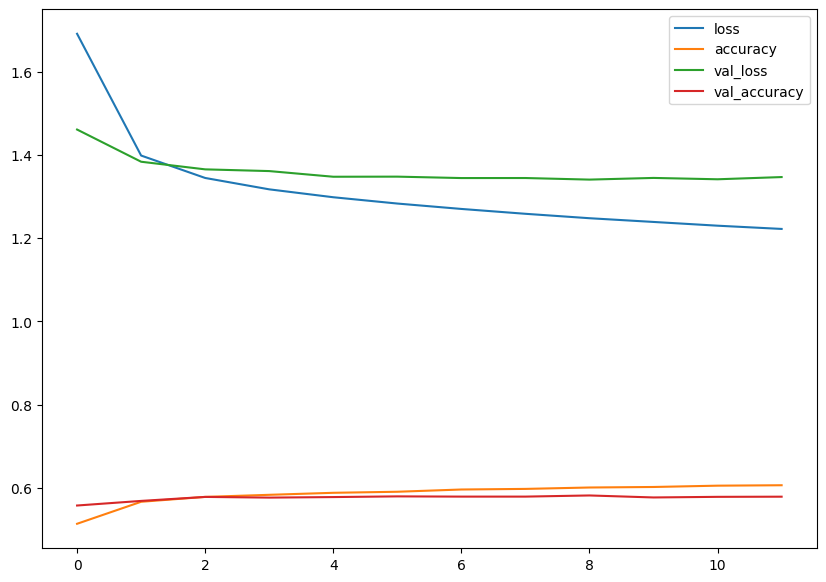

In [ ]:
pd.DataFrame(model_USE_original_history.history).plot(figsize=(10, 7));

In [ ]:
# Make predictions on the validation dataset
model_USE_original_pred_probs = model_USE_original.predict(val_sentences)
model_USE_original_pred_probs.shape, model_USE_original_pred_probs[:5] # view the first 5

170/170 [==============================] - 3s 17ms/step


((5422, 27),
 array([[6.7795748e-03, 3.4448665e-04, 6.2716128e-03, 3.4238398e-04,
         2.3221616e-03, 1.1910466e-01, 2.8052307e-03, 8.8356910e-03,
         6.7816573e-01, 7.2484760e-04, 3.2133677e-03, 1.3740538e-06,
         6.0165150e-04, 2.6113715e-02, 3.2896125e-05, 1.6075835e-03,
         1.2909796e-02, 1.3354236e-06, 5.2306270e-05, 1.1805991e-02,
         4.3055336e-03, 2.0760788e-02, 1.9018592e-06, 1.5578386e-06,
         9.2829578e-02, 2.2793412e-05, 4.1524087e-05],
        [1.9936646e-04, 3.4144116e-03, 8.8548011e-05, 2.3744725e-04,
         2.7827537e-04, 3.2329675e-02, 5.6286342e-04, 9.2047099e-03,
         5.4756445e-01, 3.8346191e-04, 8.2115160e-04, 1.7441834e-06,
         7.4963187e-05, 4.1037090e-03, 1.1894728e-04, 1.6153682e-03,
         6.0849951e-04, 4.4109875e-05, 5.8470596e-05, 4.7287755e-03,
         3.7992484e-04, 3.9031708e-01, 3.2777609e-07, 5.9122547e-05,
         2.6853159e-03, 5.1269657e-05, 6.8034125e-05],
        [3.0342143e-02, 2.3786069e-03, 4.4349395e

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_USE_original_preds = np.argmax(model_USE_original.predict(val_sentences), axis=1)
model_USE_original_preds[:10]

170/170 [==============================] - 3s 17ms/step


array([ 8,  8,  5, 13, 14,  8,  7, 13,  7,  8])

In [ ]:
# Calculate LSTM model results
model_USE_original_results = calculate_results(y_true=val_labels,
                                    y_pred=model_USE_original_preds)
model_USE_original_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 57.91220951678348,
 'precision': 0.5565796983589765,
 'recall': 0.5791220951678347,
 'f1': 0.5460661292870546}

### On balance dataset

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 1.5071819108516356,
 1: 3.403222431471019,
 2: 2.57423235201013,
 3: 4.1352657004830915,
 4: 7.5929038281979455,
 5: 0.2699598313580985,
 6: 4.0247463499133875,
 7: 0.15349622960257464,
 8: 0.1473749071204625,
 9: 2.5098765432098764,
 10: 6.318570318570319,
 11: 10.267676767676768,
 12: 8.251648909183157,
 13: 0.9053662881318192,
 14: 2.775900324287421,
 15: 7.059027777777778,
 16: 6.210003818251241,
 17: 11.086571233810497,
 18: 2.3684287170525704,
 19: 3.0068404511000186,
 20: 3.1428019323671497,
 21: 0.3946519133241125,
 22: 4.693795093795094,
 23: 5.090453834115806,
 24: 1.2619490999379268,
 25: 14.812386156648452,
 26: 1.928613779200759}

In [ ]:
# Create model using the Sequential API
model_USE = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(27, activation="softmax")
], name="model_USE")

# Compile model
model_USE.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE.summary()

Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 27)                1755      
                                                                 
Total params: 256832411 (979.74 MB)
Trainable params: 34587 (135.11 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model
model_USE_history = model_USE.fit(train_sentences,
                              train_labels,
                              class_weight=class_weights,
                              epochs=30,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[early_stopping])

Epoch 1/30
1525/1525 [==============================] - 41s 25ms/step - loss: 2.3705 - accuracy: 0.2627 - val_loss: 2.2712 - val_accuracy: 0.3054
Epoch 2/30
1525/1525 [==============================] - 36s 23ms/step - loss: 1.7950 - accuracy: 0.3196 - val_loss: 2.1156 - val_accuracy: 0.3419
Epoch 3/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.6854 - accuracy: 0.3335 - val_loss: 2.1175 - val_accuracy: 0.3266
Epoch 4/30
1525/1525 [==============================] - 36s 24ms/step - loss: 1.6204 - accuracy: 0.3435 - val_loss: 2.1551 - val_accuracy: 0.3174
Epoch 5/30
1525/1525 [==============================] - 35s 23ms/step - loss: 1.5788 - accuracy: 0.3500 - val_loss: 1.9961 - val_accuracy: 0.3624
Epoch 6/30
1525/1525 [==============================] - 35s 23ms/step - loss: 1.5413 - accuracy: 0.3561 - val_loss: 2.0260 - val_accuracy: 0.3534
Epoch 7/30
1525/1525 [==============================] - 38s 25ms/step - loss: 1.5102 - accuracy: 0.3579 - val_loss: 2.0239 -

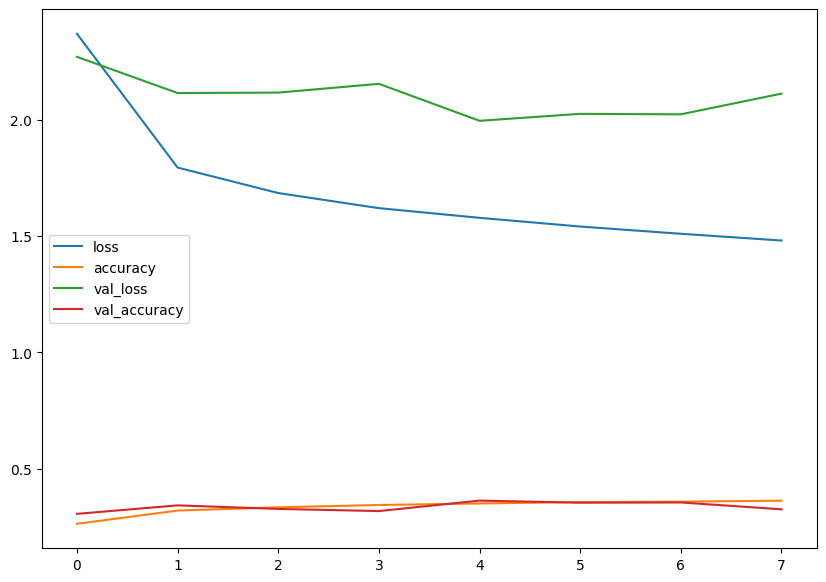

In [ ]:
pd.DataFrame(model_USE_history.history).plot(figsize=(10, 7));

In [ ]:
# Make predictions on the validation dataset
model_USE_pred_probs = model_USE.predict(val_sentences)
model_USE_pred_probs.shape, model_USE_pred_probs[:5] # view the first 5

170/170 [==============================] - 4s 19ms/step


((5422, 27),
 array([[5.39191207e-03, 1.05437473e-03, 4.95706052e-02, 1.67802616e-03,
         8.02465677e-02, 1.37054458e-01, 2.76302211e-02, 7.14617362e-03,
         2.34577850e-01, 4.83377324e-03, 2.94379499e-02, 1.50137384e-05,
         4.37082211e-03, 2.16037873e-02, 4.03025188e-04, 1.12918429e-02,
         1.26389548e-01, 1.81492316e-04, 1.19923346e-03, 5.67207858e-02,
         1.33574707e-02, 1.43991904e-02, 1.38589930e-05, 7.54062203e-05,
         1.70957267e-01, 2.93254452e-05, 3.70043446e-04],
        [2.72077537e-04, 1.85254104e-02, 2.09696451e-03, 3.60050285e-03,
         1.18605737e-02, 5.31030148e-02, 2.43446743e-03, 1.20827006e-02,
         1.32571191e-01, 4.63306578e-03, 1.40981115e-02, 7.64570996e-06,
         2.61570350e-03, 1.13771632e-02, 1.28096761e-03, 1.58162490e-02,
         6.19355729e-03, 7.00057577e-03, 1.87082763e-03, 4.97595146e-02,
         1.62534730e-03, 6.36866510e-01, 2.43576528e-06, 2.09307158e-03,
         7.60369282e-03, 4.38798364e-04, 1.69708816e-

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_USE_preds = np.argmax(model_USE.predict(val_sentences), axis=1)
model_USE_preds[:10]

170/170 [==============================] - 3s 17ms/step


array([ 8, 21,  2, 13, 14,  6, 12, 13,  7, 25])

In [ ]:
# Calculate LSTM model results
model_USE_results = calculate_results(y_true=val_labels,
                                    y_pred=model_USE_preds)
model_USE_results

{'accuracy': 32.49723349317595,
 'precision': 0.5685543057422683,
 'recall': 0.3249723349317595,
 'f1': 0.35988489324026135}